In [ ]:
!pip install tensorflow

In [ ]:
!pip install torch torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
enable_wandb = True
use_gpu = True

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import time
import requests
import zipfile
import io

In [ ]:
gpu_available = torch.cuda.is_available()
gpu_available

True

In [ ]:
configs = {
    "experiment_name": "ViT Model",
    "freeze_feature_extraction_layers": False,
    "pretrained": False,
    "efficientnet":False,
    "use_transformer": False,  # Add parameter for using transformer-based models
    "data_augmentation": True,
    "transfer_learning": True,

    # Data
    "img_dimensions": (3, 524, 524),
    "batch_size": 32,
    "num_classes": 9,

    # Model architecture
    "filter_sizes": [5,5],
    "kernel_size": 3,
    "stride": 2,
    "padding": 1,

    # Optimization
    "learning_rate": 0.01,
    "epochs": 10,
    "weight_decay": 0.0001,

    # Additional parameters for hyperparameter tuning and handling class imbalance
    "transformer_layers": 12,
    "hidden_dim": 768,
    "dropout_rate": 0.3,
    "use_class_weights": False,  # Flag to enable class weights
    "class_weight_strategy": "balanced",
    "data_augmentation_strategy": "random_crop",
    "track_metrics": ["accuracy", "precision", "recall", "f1_score"],
    "generate_visualizations": True,  # Flag to generate visualizations (confusion matrix, histograms, etc.)
}

In [ ]:
# Download image dataset zip
#url = "https://archive.ics.uci.edu/static/public/908/realwaste.zip"
#response = requests.get(url)
#response.raise_for_status()

In [ ]:
# Unzip the file
#with zipfile.ZipFile(io.BytesIO(response.content)) as z:
#    z.extractall()

In [ ]:
"""
# Created train and test folders, and moved images from OG RealWaste to the two folders, with 20% in testing and 80% in training.
import os
import shutil
from sklearn.model_selection import train_test_split

# OG Directory of where the images were located
root_dir = '/projectnb/ba865/projects/B1_Group10/realwaste-main/RealWaste'

# Define directory to create train and test folders
train_test_dir = '/projectnb/ba865/projects/B1_Group10/realwaste-main'
train_dir = os.path.join(train_test_dir, 'train')
test_dir = os.path.join(train_test_dir, 'test')

# Create train and test folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through each waste type folder
for waste_type in os.listdir(root_dir):
    waste_type_dir = os.path.join(root_dir, waste_type)

    # Collect file paths of images in the waste type folder
    image_files = [os.path.join(waste_type_dir, filename) for filename in os.listdir(waste_type_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]

    # Split the dataset into training and testing sets
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

    # Move training images to the train folder
    train_waste_type_dir = os.path.join(train_dir, waste_type)
    os.makedirs(train_waste_type_dir, exist_ok=True)
    for file in train_files:
        shutil.move(file, train_waste_type_dir)

    # Move testing images to the test folder
    test_waste_type_dir = os.path.join(test_dir, waste_type)
    os.makedirs(test_waste_type_dir, exist_ok=True)
    for file in test_files:
        shutil.move(file, test_waste_type_dir)
        """

"\n# Created train and test folders, and moved images from OG RealWaste to the two folders, with 20% in testing and 80% in training.\nimport os\nimport shutil\nfrom sklearn.model_selection import train_test_split\n\n# OG Directory of where the images were located\nroot_dir = '/projectnb/ba865/projects/B1_Group10/realwaste-main/RealWaste'\n\n# Define directory to create train and test folders\ntrain_test_dir = '/projectnb/ba865/projects/B1_Group10/realwaste-main'\ntrain_dir = os.path.join(train_test_dir, 'train')\ntest_dir = os.path.join(train_test_dir, 'test')\n\n# Create train and test folders\nos.makedirs(train_dir, exist_ok=True)\nos.makedirs(test_dir, exist_ok=True)\n\n# Iterate through each waste type folder\nfor waste_type in os.listdir(root_dir):\n    waste_type_dir = os.path.join(root_dir, waste_type)\n\n    # Collect file paths of images in the waste type folder\n    image_files = [os.path.join(waste_type_dir, filename) for filename in os.listdir(waste_type_dir) if filename.en

In [ ]:
# Transformations
if configs["data_augmentation"]:
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.Resize(524),
        transforms.RandomCrop(524),
        transforms.RandomRotation(45),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
else:
    transform = transforms.Compose([
        transforms.Resize(524),
        transforms.CenterCrop(524),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [ ]:
# Define paths to the og dataset, train, and test folders
train_dir = '/content/drive/MyDrive/project/train'
test_dir = '/content/drive/MyDrive/project/test'
dataset_dir = '/content/drive/MyDrive/project/RealWaste (2)'

In [ ]:
# Set train and test dataset
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader objects for train and test datasets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#Checking Imbalances#

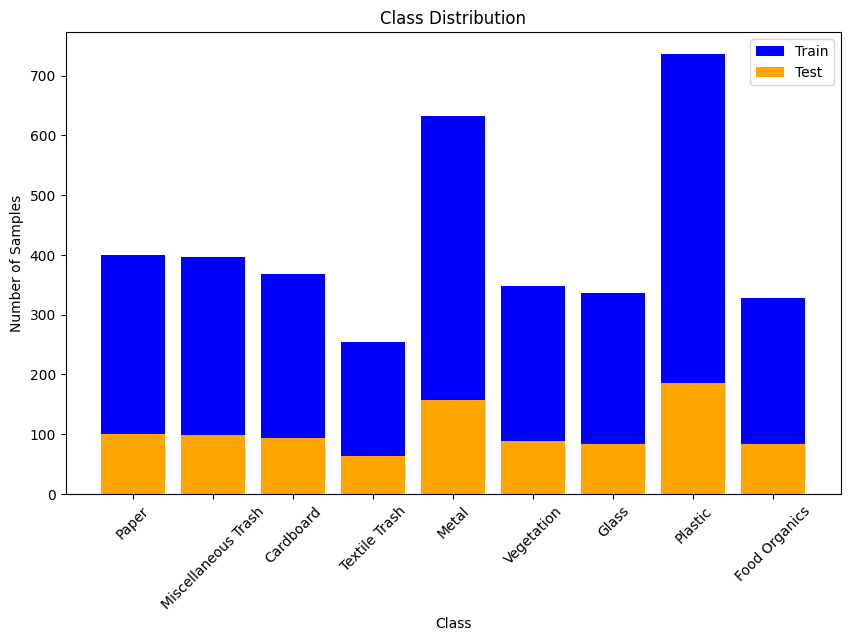

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Get the list of classes (subfolders) in the train directory
classes = os.listdir(train_dir)

# Count the number of samples per class in the train dataset
train_class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

# Count the number of samples per class in the test dataset
test_class_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in classes}

# Visualize class distribution in the train dataset
plt.figure(figsize=(10, 6))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='blue', label='Train')
plt.bar(test_class_counts.keys(), test_class_counts.values(), color='orange', label='Test')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
train_num_samples = sum(train_class_counts.values())
test_num_samples = sum(test_class_counts.values())
num_classes = len(classes)
print(f"Number of classes: {num_classes}")
print(f"Total number of samples in train dataset: {train_num_samples}")
print(f"Total number of samples in test dataset: {test_num_samples}")
print(f"Average number of samples per class in train dataset: {train_num_samples / num_classes}")
print(f"Average number of samples per class in test dataset: {test_num_samples / num_classes}")

Number of classes: 9
Total number of samples in train dataset: 3798
Total number of samples in test dataset: 954
Average number of samples per class in train dataset: 422.0
Average number of samples per class in test dataset: 106.0


In [ ]:
#Addressing imbalance through weighted loss function#

In [ ]:
categories = os.listdir(dataset_dir)

class_counts = {}

for category in categories:
    category_dir = os.path.join(dataset_dir, category)

    if os.path.isdir(category_dir):
        num_images = len([filename for filename in os.listdir(category_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[category] = num_images

for category, count in class_counts.items():
    print(f'{category}: {count} images')

Vegetation: 436 images
Miscellaneous Trash: 495 images
Metal: 790 images
Food Organics: 411 images
Glass: 420 images
Cardboard: 477 images
Paper: 500 images
Plastic: 921 images
Textile Trash: 318 images


In [ ]:
total_samples = sum(class_counts.values())

# Calculate the weight for each class
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Print the weights for each class
for cls, weight in class_weights.items():
    print(f'{cls}_weight = {weight:.2f}')

Vegetation_weight = 10.94
Miscellaneous Trash_weight = 9.63
Metal_weight = 6.04
Food Organics_weight = 11.60
Glass_weight = 11.35
Cardboard_weight = 10.00
Paper_weight = 9.54
Plastic_weight = 5.18
Textile Trash_weight = 14.99


In [ ]:
class_counts = {
    'cardboard': 461,
    'food_organics': 411,
    'glass': 420,
    'metal': 790,
    'miscellaneous_trash': 495,
    'paper': 500,
    'plastic': 921,
    'textile_trash': 318,
    'vegetation': 436
}

In [ ]:
total_samples = sum(class_counts.values())

class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

cardboard_weight = class_weights['cardboard']
food_organics_weight = class_weights['food_organics']
glass_weight = class_weights['glass']
metal_weight = class_weights['metal']
miscellaneous_trash_weight = class_weights['miscellaneous_trash']
paper_weight = class_weights['paper']
plastic_weight = class_weights['plastic']
textile_trash_weight = class_weights['textile_trash']
vegetation_weight = class_weights['vegetation']

In [ ]:
print(f'Cardboard weight: {cardboard_weight:.2f}')
print(f'Food Organics weight: {food_organics_weight:.2f}')
print(f'Glass weight: {glass_weight:.2f}')
print(f'Metal weight: {metal_weight:.2f}')
print(f'Miscellaneous Trash weight: {miscellaneous_trash_weight:.2f}')
print(f'Paper weight: {paper_weight:.2f}')
print(f'Plastic weight: {plastic_weight:.2f}')
print(f'Textile Trash weight: {textile_trash_weight:.2f}')
print(f'Vegetation weight: {vegetation_weight:.2f}')

Cardboard weight: 10.31
Food Organics weight: 11.56
Glass weight: 11.31
Metal weight: 6.02
Miscellaneous Trash weight: 9.60
Paper weight: 9.50
Plastic weight: 5.16
Textile Trash weight: 14.94
Vegetation weight: 10.90


In [ ]:
weights = torch.tensor([cardboard_weight, food_organics_weight, glass_weight,
                        metal_weight, miscellaneous_trash_weight, paper_weight,
                        plastic_weight, textile_trash_weight, vegetation_weight])

loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

In [ ]:
#Now we are done with preprocessing the dataset and handled class imbalance. This is ready for modeling.#

## KNN

In [ ]:
# Extracts and returns image data and labels from a dataset as NumPy arrays.
def extract_features_and_labels(dataset):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    features = []
    labels = []
    for images, label in dataloader:
        # Flatten the image data
        features.append(images.numpy())#.flatten()
        labels.append(label.numpy()[0])
    return np.array(features), np.array(labels)

# Extract features and labels
X_train, y_train = extract_features_and_labels(train_dataset)
X_test, y_test = extract_features_and_labels(test_dataset)

In [ ]:
X_train.shape

(3798, 1, 3, 524, 524)

In [ ]:
# Reshape images to 224x224x3 and display their shapes.
X_train = np.reshape(X_train, (X_train.shape[0],524,524,3))
X_test = np.reshape(X_test, (X_test.shape[0],524,524,3))
print(X_test.shape,X_train.shape)

(954, 524, 524, 3) (3798, 524, 524, 3)


In [ ]:
# Saving training and testing data arrays to .npy files.
import numpy as np

np.save('X_train.npy', X_train)  # This saves the X_train array
np.save('y_train.npy', y_train)

np.save('X_test.npy', X_test)  # This saves the X_train array
np.save('y_test.npy', y_test)


In [ ]:
import numpy as np

# Load X_train from .npy file
X_train = np.load('X_train.npy')

# Load y_train from .npy file
y_train = np.load('y_train.npy')

# Load X_test from .npy file
X_test = np.load('X_test.npy')

# Load y_test from .npy file
y_test = np.load('y_test.npy')


In [ ]:
# Install the scikit-learn library.
!pip install scikit-learn

In [ ]:
# Import K-Nearest Neighbors classifier and evaluation metrics from scikit-learn.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Reshape training and testing data into flat arrays for the KNN model.
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Initialize the K-Nearest Neighbors classifier with 3 neighbors.
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the KNN model on the reshaped training data.
knn.fit(X_train_reshaped, y_train)

# Predict using the KNN model on the testing data and evaluate performance.
y_pred = knn.predict(X_test_reshaped)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.09      0.09      0.09        93
           1       0.23      0.14      0.18        83
           2       0.16      0.83      0.27        84
           3       0.28      0.22      0.25       158
           4       0.26      0.12      0.16        99
           5       0.54      0.13      0.21       100
           6       0.32      0.32      0.32       185
           7       0.43      0.05      0.08        64
           8       0.00      0.00      0.00        88

    accuracy                           0.22       954
   macro avg       0.26      0.21      0.17       954
weighted avg       0.26      0.22      0.20       954

Accuracy: 0.2222222222222222


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN

In [ ]:
import torch.nn as nn
class CNN(nn.Module):
  def __init__(self,num_classes):
    super(CNN, self).__init__()
    self.conv1= nn.Conv2d(3, 16, configs["kernel_size"], stride=configs["stride"], padding=configs["padding"])
    self.conv2= nn.Conv2d(16, 32, configs["kernel_size"], stride=configs["stride"], padding=configs["padding"])
    self.pool= nn.MaxPool2d(2,2)
    self.fc1= nn.Linear(33*33*32, 9)

  def forward(self, x):
    x= self.pool(torch.relu(self.conv1(x)))
    x= self.pool(torch.relu(self.conv2(x)))
    x= x.view(-1, 33*33*32)
    x= self.fc1(x)
    return x

model= CNN(num_classes=9)

In [ ]:
# Loss and Optimizer
criterion = loss_fn
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=configs["learning_rate"], weight_decay=configs["weight_decay"])

In [ ]:
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from torchinfo import summary

summary(model, (3, 524, 524))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 9]                    --
├─Conv2d: 1-1                            [16, 262, 262]            448
├─MaxPool2d: 1-2                         [16, 131, 131]            --
├─Conv2d: 1-3                            [32, 66, 66]              4,640
├─MaxPool2d: 1-4                         [32, 33, 33]              --
├─Linear: 1-5                            [1, 9]                    313,641
Total params: 318,729
Trainable params: 318,729
Non-trainable params: 0
Total mult-adds (M): 11.99
Input size (MB): 3.29
Forward/backward pass size (MB): 9.90
Params size (MB): 1.27
Estimated Total Size (MB): 14.47

In [ ]:
gpu_available = torch.cuda.is_available()
use_gpu = True
if gpu_available and use_gpu:
  model = model.cuda()

In [ ]:
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: asell (asellbu). Use `wandb login --relogin` to force relogin


In [ ]:
if enable_wandb:
  wandb.init(
    # Set the project where this run will be logged
    project="BA865-Group-10",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=configs["experiment_name"],
    # Track hyperparameters and run metadata
    config=configs)

In [ ]:
best= 0.0
def train_model(model, train_loader, test_loader, epochs):
    global best

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()
            # Forward
            outputs= model(images)
            # loss
            if gpu_available and use_gpu:
                criterion.cuda()
            loss=criterion(outputs, labels)

            # Backward and Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")
        if enable_wandb:
            wandb.log({"loss": loss})

        model.eval()
        with torch.no_grad():
            correct=0
            total=0
            for images, labels in test_loader:
                if gpu_available and use_gpu:
                    images = images.cuda()
                    labels = labels.cuda()
                outputs= model(images)
                _, prediction= torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (prediction == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}, Test Accuracy: {accuracy:.2f}%")

        if accuracy > best:
            best = accuracy
            torch.save(model.state_dict(), "./best_model.pt")
            print("Saving best model...")

        if enable_wandb:
            # Log test accuracy at the end of each epoch
            wandb.log({"epoch": epoch + 1, "test_accuracy": accuracy})  # Log test accuracy

    return best


best = train_model(model, train_loader, test_loader, epochs=10)

Epoch [1/10], Loss: 2.0553064346313477
Epoch 1, Test Accuracy: 35.22%
Saving best model...
Epoch [2/10], Loss: 1.821250081062317
Epoch 2, Test Accuracy: 30.29%
Epoch [3/10], Loss: 1.4250530004501343
Epoch 3, Test Accuracy: 45.81%
Saving best model...
Epoch [4/10], Loss: 1.1914483308792114
Epoch 4, Test Accuracy: 48.85%
Saving best model...
Epoch [5/10], Loss: 1.6216615438461304
Epoch 5, Test Accuracy: 50.00%
Saving best model...
Epoch [6/10], Loss: 1.0892902612686157
Epoch 6, Test Accuracy: 49.48%
Epoch [7/10], Loss: 0.8815358877182007
Epoch 7, Test Accuracy: 51.89%
Saving best model...
Epoch [8/10], Loss: 0.9110730886459351
Epoch 8, Test Accuracy: 48.32%
Epoch [9/10], Loss: 1.0498801469802856
Epoch 9, Test Accuracy: 54.51%
Saving best model...
Epoch [10/10], Loss: 1.3383457660675049
Epoch 10, Test Accuracy: 48.11%


In [ ]:
print("Last model performance on Test set:", best)

# Load the best model
best_model = CNN(num_classes=9)
best_model.load_state_dict(torch.load("./best_model.pt"))

# Calculate accuracy of the best model
best_model_accuracy = best  # Use the best accuracy from training
print("Best model performance on Test set:", best_model_accuracy)

if enable_wandb:
    wandb.summary['Test Accuracy'] = best_model_accuracy

Last model performance on Test set: 54.507337526205454
Best model performance on Test set: 54.507337526205454


In [ ]:
if enable_wandb:
  wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▄▃▅▂▁▁▂▃
test_accuracy,▂▁▅▆▇▇▇▆█▆
Test Accuracy,54.50734
epoch,10
loss,1.33835
test_accuracy,48.11321


In [ ]:
# https://api.wandb.ai/links/asellbu/9cdgmqaz

## RESENET with KNN

In [ ]:
# Extracts features and labels using a pretrained model
import torchvision.models as models
def extract_features(dataset, model, device='cuda'):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    features = []
    labels = []

    model.eval()
    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(device)
            output = model(images)
            features.extend(output.cpu().numpy())
            labels.extend(label.numpy())

    return np.array(features), np.array(labels)

# Use a pre-trained ResNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()  # Modify the model to output features directly
resnet = resnet.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Extract features and labels from training and testing datasets
X_train, y_train = extract_features(train_dataset, resnet, device)
X_test, y_test = extract_features(test_dataset, resnet, device)


In [ ]:
# Initializing KNN
knn = KNeighborsClassifier(n_neighbors=3)

# Training the model
knn.fit(X_train, y_train)

# Making predictions and evaluate
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.87      0.83        93
           1       0.90      0.93      0.91        83
           2       0.81      0.94      0.87        84
           3       0.80      0.87      0.83       158
           4       0.91      0.68      0.77        99
           5       0.87      0.84      0.85       100
           6       0.88      0.83      0.85       185
           7       0.85      0.81      0.83        64
           8       0.93      0.94      0.94        88

    accuracy                           0.85       954
   macro avg       0.86      0.86      0.85       954
weighted avg       0.86      0.85      0.85       954

Accuracy: 0.8532494758909853


#using log regression

In [ ]:
# Using Logistic Regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=100, solver='lbfgs', multi_class='multinomial')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.83      0.86        93
           1       0.93      0.93      0.93        83
           2       0.90      0.90      0.90        84
           3       0.85      0.87      0.86       158
           4       0.73      0.75      0.74        99
           5       0.88      0.92      0.90       100
           6       0.85      0.84      0.85       185
           7       0.85      0.80      0.82        64
           8       0.97      0.95      0.96        88

    accuracy                           0.86       954
   macro avg       0.87      0.87      0.87       954
weighted avg       0.87      0.86      0.86       954



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#ViT model

In [ ]:
!pip install torch torchvision transformers


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from huggingface_hub import notebook_login

# Authenticate with Hugging Face
notebook_login()

# Set the device to run the model on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the image processor and model
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device)

# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model input size
    transforms.ToTensor()           # Convert images to tensors
])

# Load the dataset
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/project/train', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def predict_images(dataloader, model, image_processor):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)  # Move images to the device
            processed_images = image_processor(images=images)  # Process images with ViTImageProcessor
            outputs = model(**processed_images)
            _, predicted = torch.max(outputs.logits, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

# Example usage
predictions = predict_images(test_loader, model, image_processor)
print(predictions)





AttributeError: 'list' object has no attribute 'dtype'